<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/Estudio_mapeoporcolores_dECM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sube tu archivo .xlsx del plate reader


Saving dECM1_Berta (2).xlsx to dECM1_Berta (2) (2).xlsx
Usando archivo: dECM1_Berta (2) (2).xlsx
  well  time_min     OD
0   B4       0.2  0.169
1   B5       0.2  0.167
2   B6       0.2  0.169
3   C1       0.2  0.182
4   C2       0.2  0.175
Nº de lecturas: 4719, nº de wells: 39, nº tiempos: 121
Wells sin condición: 0
   baseline   plateau  delta_OD  slope_max        t50   lag_time  sd_plateau  \
0    0.1694  0.167048 -0.002352      0.003   4.792063   0.482381    0.000805   
1    0.1666  0.166333 -0.000267      0.002   2.733333   2.613333    0.000966   
2    0.1700  0.169333 -0.000667      0.007   0.866667   1.166667    0.001853   
3    0.1816  0.180762 -0.000838      0.001   1.019048   0.641905    0.000436   
4    0.1750  0.179571  0.004571      0.001  36.485714  20.428571    0.000598   

  well  condition  
0   B4    Control  
1   B5    Control  
2   B6    Control  
3   C1  Bov no pH  
4   C2  Bov no pH  
Nº de wells resumidos: 39
PCA 1 – Validación (incluye Bov/Rat/Control y dECM) – 

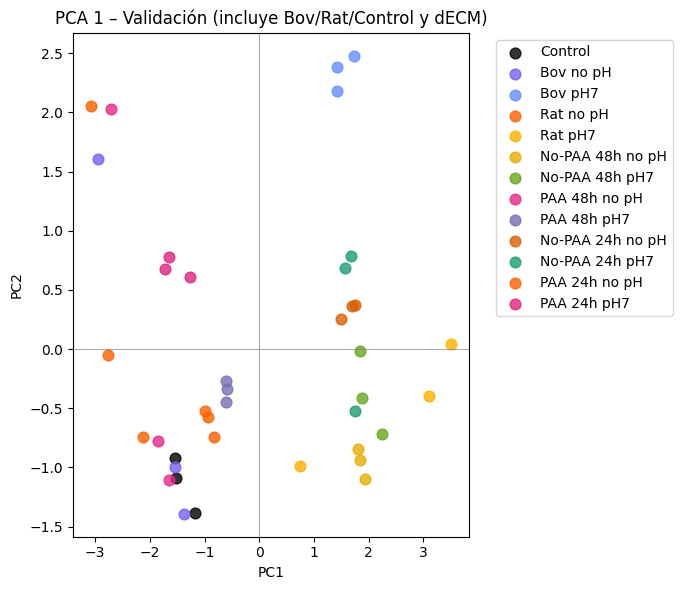

PCA 2 – dECM (PAA / No PAA, 24h / 48h, pH7 / no pH) – Varianza explicada: PC1=0.55, PC2=0.15


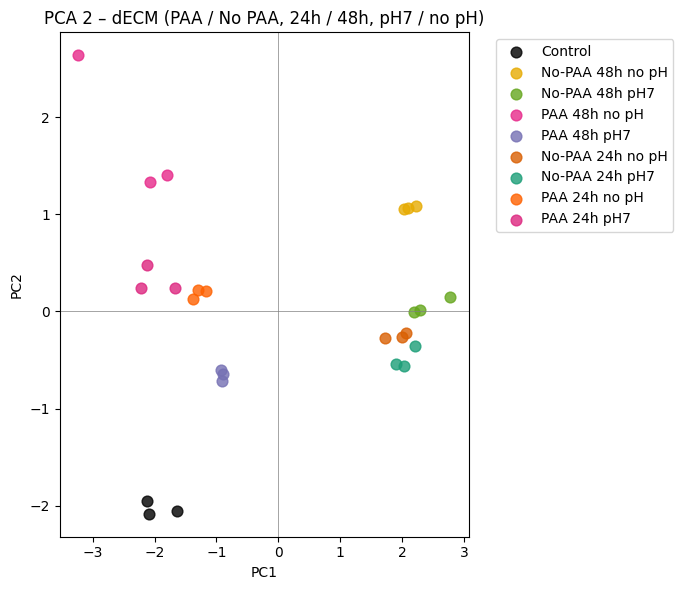

In [12]:
# ============================================
# 0. IMPORTAR LIBRERÍAS
# ============================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Para subir el archivo desde tu ordenador
from google.colab import files

# ============================================
# 1. SUBIR Y LEER EL EXCEL DEL PLATE READER
# ============================================

print("Sube tu archivo .xlsx del plate reader")
uploaded = files.upload()

# Coger el nombre del primer archivo subido
fname = list(uploaded.keys())[0]
print(f"Usando archivo: {fname}")

# Lo leemos sin cabeceras porque Gen5 mete mucha morralla arriba
raw = pd.read_excel(fname, header=None)

# ============================================
# 2. FUNCIONES AUXILIARES PARA PARSEAR EL FORMATO GEN5
# ============================================

def parse_time_minutes(label):
    """
    Convierte un texto tipo '350 - Time 1 (0:00:12)'
    a minutos (float), p.ej. 0.2, 1.2, 2.2...
    """
    m = re.search(r"\((\d+):(\d+):(\d+)\)", label)
    if not m:
        return None
    h = int(m.group(1))
    mi = int(m.group(2))
    s = int(m.group(3))
    return h * 60 + mi + s / 60.0


def find_header_row(df, time_row):
    """
    A partir de la fila donde pone '350 - Time X (...)',
    busca hacia abajo dónde está la fila con los números de columna (1,2,3...12)
    y justo debajo deben venir las filas A,B,C,...H.
    """
    for r in range(time_row + 1, time_row + 10):
        row = df.iloc[r]
        # la fila de cabecera tiene un '1' en la 3ª columna (índice 2)
        if pd.notna(row[2]) and str(row[2]).isdigit():
            next_row = df.iloc[r + 1]
            if next_row[1] == "A":
                return r
    return None


def extract_long_table(raw_df):
    """
    Pasa de formato ancho (bloques 8x12 por tiempo) a formato largo:
    columnas: well, time_min, OD
    """
    time_rows = []
    time_labels = []

    # localizar todas las filas donde empieza un bloque de tiempo
    for idx, val in raw_df[0].items():
        if isinstance(val, str) and val.startswith("350 - Time"):
            time_rows.append(idx)
            time_labels.append(val)

    rows_list = []

    for tr, label in zip(time_rows, time_labels):
        t = parse_time_minutes(label)
        header_row = find_header_row(raw_df, tr)
        header = raw_df.iloc[header_row]

        # columnas útiles (1,2,3,...,12)
        cols = [i for i, v in header.items() if pd.notna(v)]

        # filas A-H con los datos
        for offset, letter in enumerate(list("ABCDEFGH")):
            r = header_row + 1 + offset
            if r >= len(raw_df):
                continue
            row = raw_df.iloc[r]
            if row[1] != letter:  # por si acaso
                continue

            for c in cols:
                val = row[c]
                if pd.isna(val):
                    continue
                colnum = int(header[c])
                well = f"{letter}{colnum}"
                rows_list.append({
                    "well": well,
                    "time_min": t,
                    "OD": float(val)
                })

    long_df = pd.DataFrame(rows_list)
    return long_df


long_df = extract_long_table(raw)
print(long_df.head())
print(f"Nº de lecturas: {len(long_df)}, nº de wells: {long_df['well'].nunique()}, nº tiempos: {long_df['time_min'].nunique()}")

# ============================================
# 3. MAPEAR CADA WELL A SU CONDICIÓN
# ============================================

condition_map = {}

def add_condition(cond_name, wells):
    for w in wells:
        condition_map[w] = cond_name

add_condition("Control", ["B4", "B5", "B6"])
add_condition("Bov pH7", ["C4", "C5", "C6"])
add_condition("Bov no pH", ["C1", "C2", "C3"])
add_condition("Rat pH7", ["D4", "D5", "D6"])
add_condition("Rat no pH", ["D1", "D2", "D3"])
add_condition("PAA 24h pH7", ["H4", "H5", "H6"])
add_condition("PAA 24h no pH", ["H1", "H2", "H3"])
add_condition("No-PAA 24h pH7", ["G4", "G5", "G6"])
add_condition("No-PAA 24h no pH", ["G1", "G2", "G3"])
add_condition("PAA 48h pH7", ["F4", "F5", "F6"])
add_condition("PAA 48h no pH", ["F1", "F2", "F3"])
add_condition("No-PAA 48h pH7", ["E4", "E5", "E6"])
add_condition("No-PAA 48h no pH", ["E1", "E2", "E3"])

long_df["condition"] = long_df["well"].map(condition_map)

# Comprobación rápida: no debería haber NaNs en "condition"
print("Wells sin condición:", long_df["condition"].isna().sum())

# ============================================
# 4. FUNCIÓN PARA RESUMIR CADA CURVA DE CADA WELL
# ============================================

def summarize_well(df_well, baseline_max_min=5, plateau_window_min=20):
    """
    A partir de la curva OD vs tiempo de UN well, calcula:
      - baseline: media hasta baseline_max_min (p.ej. 5 min)
      - plateau: media de los últimos plateau_window_min minutos
      - delta_OD = plateau - baseline
      - slope_max: pendiente máxima (dOD/dt)
      - t50: tiempo para alcanzar el 50% de la gelificación
      - lag_time: tiempo para cruzar el 5% de la gelificación
      - sd_plateau: desviación típica de la meseta
    """

    df_well = df_well.sort_values("time_min")
    t = df_well["time_min"].to_numpy()
    y = df_well["OD"].to_numpy()

    # baseline = media de los primeros minutos
    baseline_mask = t <= baseline_max_min
    baseline = float(np.mean(y[baseline_mask]))

    # plateau = media de los últimos minutos
    plateau_mask = t >= (t.max() - plateau_window_min)
    plateau = float(np.mean(y[plateau_mask]))

    delta = plateau - baseline

    # pendiente máxima
    dt = np.diff(t)
    dy = np.diff(y)
    slope_max = float(np.max(dy / dt))

    # tiempos característicos
    target_50 = baseline + 0.5 * delta
    target_lag = baseline + 0.05 * delta

    t50 = np.nan
    lag_time = np.nan

    for i in range(1, len(t)):
        # cruzar 50%
        if np.isnan(t50) and ((y[i-1] <= target_50 <= y[i]) or (y[i-1] >= target_50 >= y[i])):
            frac = (target_50 - y[i-1]) / (y[i] - y[i-1]) if y[i] != y[i-1] else 0
            t50 = t[i-1] + frac * (t[i] - t[i-1])

        # cruzar 5% (lag)
        if np.isnan(lag_time) and ((y[i-1] <= target_lag <= y[i]) or (y[i-1] >= target_lag >= y[i])):
            frac = (target_lag - y[i-1]) / (y[i] - y[i-1]) if y[i] != y[i-1] else 0
            lag_time = t[i-1] + frac * (t[i] - t[i-1])

    # ruido en la meseta
    sd_plateau = float(np.std(y[plateau_mask], ddof=1))

    return {
        "baseline": baseline,
        "plateau": plateau,
        "delta_OD": delta,
        "slope_max": slope_max,
        "t50": t50,
        "lag_time": lag_time,
        "sd_plateau": sd_plateau
    }

# ============================================
# 5. APLICAR RESUMEN A CADA WELL (3 réplicas por condición)
# ============================================

summaries = []

for well, sub in long_df.groupby("well"):
    stats = summarize_well(sub)
    stats["well"] = well
    stats["condition"] = condition_map[well]
    summaries.append(stats)

summary_df = pd.DataFrame(summaries)
print(summary_df.head())
print("Nº de wells resumidos:", len(summary_df))

# ============================================
# 6. PCA – FUNCIÓN GENÉRICA PARA HACERLA Y PINTARLA
# ============================================

# Paleta de colores "colorblind friendly" similar a la que usaba Darcy
color_palette = {
    "Control": "#000000",
    "Bov pH7": "#648FFF",
    "Bov no pH": "#785EF0",
    "Rat pH7": "#FFB000",
    "Rat no pH": "#FE6100",
    "PAA 24h pH7": "#DC267F",
    "PAA 24h no pH": "#FE6100",
    "No-PAA 24h pH7": "#1b9e77",
    "No-PAA 24h no pH": "#d95f02",
    "PAA 48h pH7": "#7570b3",
    "PAA 48h no pH": "#e7298a",
    "No-PAA 48h pH7": "#66a61e",
    "No-PAA 48h no pH": "#e6ab02",
}

features = ["baseline", "plateau", "delta_OD", "slope_max", "t50", "lag_time", "sd_plateau"]

def run_pca_plot(df_in, title="PCA"):
    # Escalar variables
    X = df_in[features].values
    X_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)

    df_plot = df_in.copy()
    df_plot["PC1"] = pcs[:, 0]
    df_plot["PC2"] = pcs[:, 1]

    print(f"{title} – Varianza explicada: PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f}")

    plt.figure(figsize=(7,6))
    for cond in df_plot["condition"].unique():
        sub = df_plot[df_plot["condition"] == cond]
        plt.scatter(sub["PC1"], sub["PC2"],
                    label=cond,
                    alpha=0.8,
                    s=60,
                    c=color_palette.get(cond, "#999999"))

    plt.axhline(0, color="grey", linewidth=0.5)
    plt.axvline(0, color="grey", linewidth=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ============================================
# 7. PCA 1 – VALIDACIÓN (incluye Bov/Rat/Control y dECM)
# ============================================

run_pca_plot(summary_df, title="PCA 1 – Validación (incluye Bov/Rat/Control y dECM)")

# ============================================
# 8. PCA 2 – ANÁLISIS BIOLÓGICO (solo dECM, sin Bov/Rat)
# ============================================

mask_decM = ~summary_df["condition"].isin(["Bov pH7", "Bov no pH", "Rat pH7", "Rat no pH"])
summary_decM = summary_df[mask_decM].reset_index(drop=True)

run_pca_plot(summary_decM, title="PCA 2 – dECM (PAA / No PAA, 24h / 48h, pH7 / no pH)")


/tmp/ipython-input-3517288058.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="condition", y=param, data=df,
/tmp/ipython-input-3517288058.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="condition", y=param, data=df,


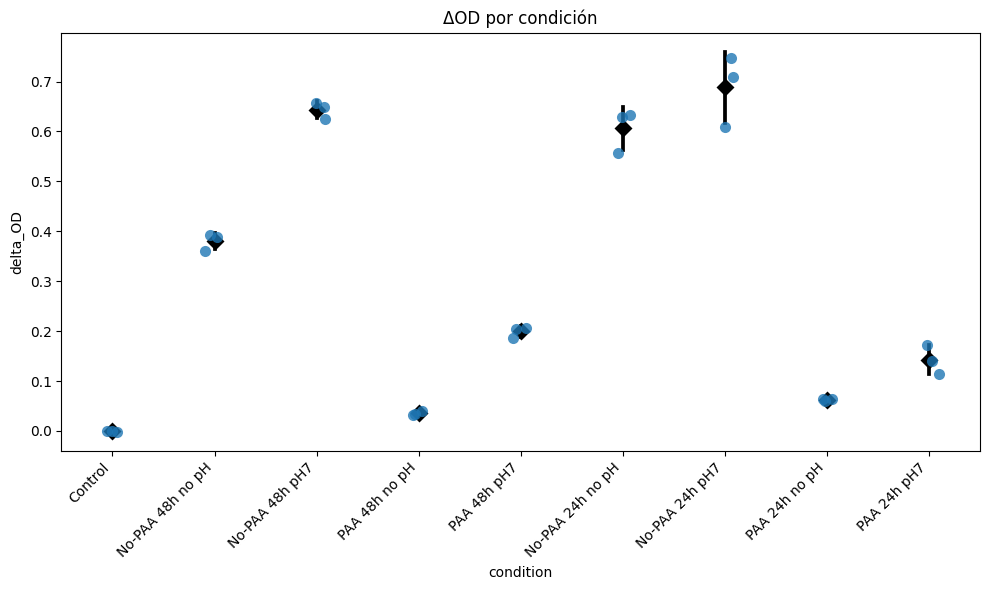

/tmp/ipython-input-3517288058.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="condition", y=param, data=df,
/tmp/ipython-input-3517288058.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="condition", y=param, data=df,


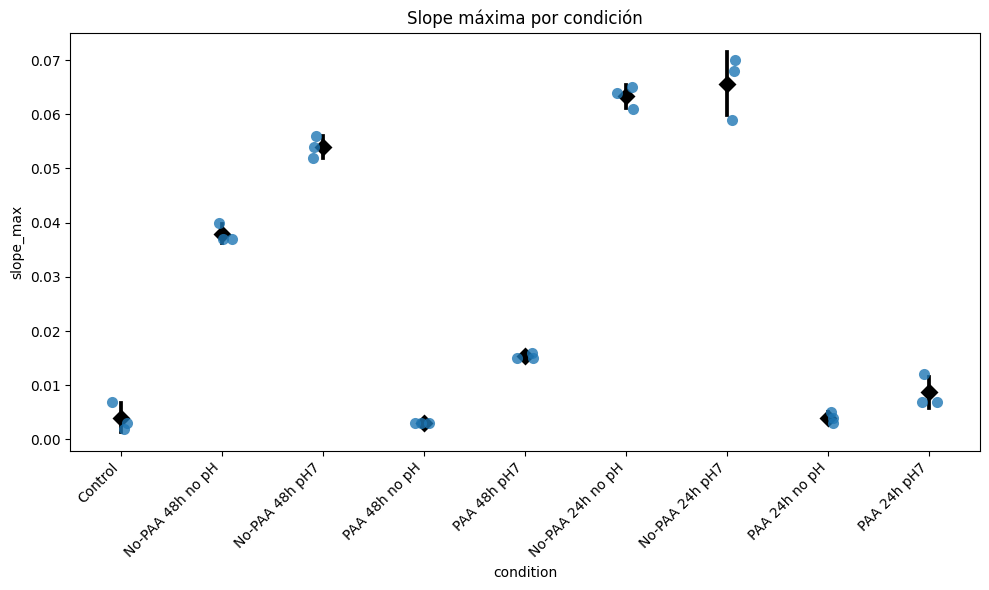

/tmp/ipython-input-3517288058.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="condition", y=param, data=df,
/tmp/ipython-input-3517288058.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="condition", y=param, data=df,


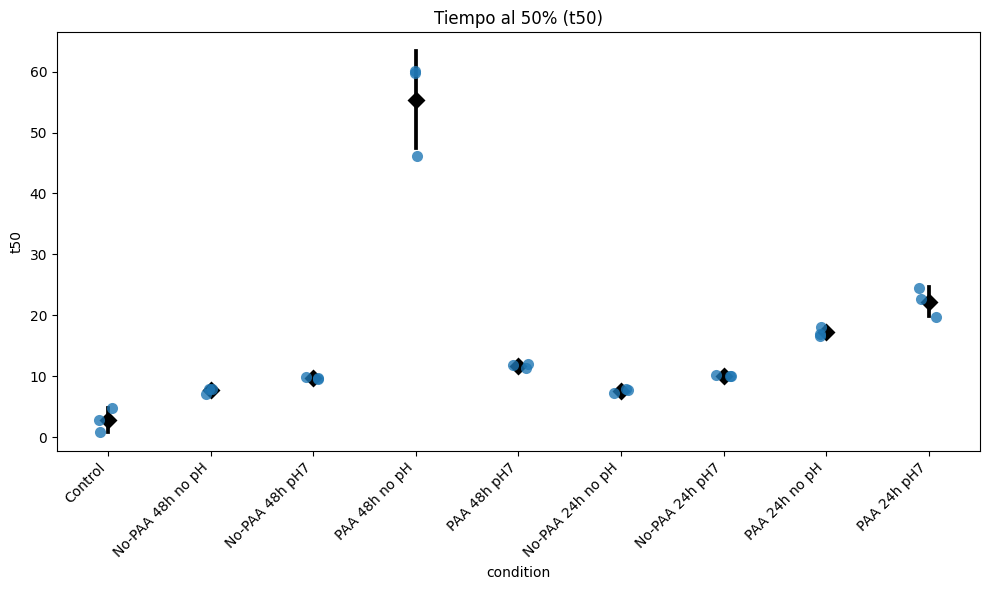

/tmp/ipython-input-3517288058.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="condition", y=param, data=df,
/tmp/ipython-input-3517288058.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="condition", y=param, data=df,


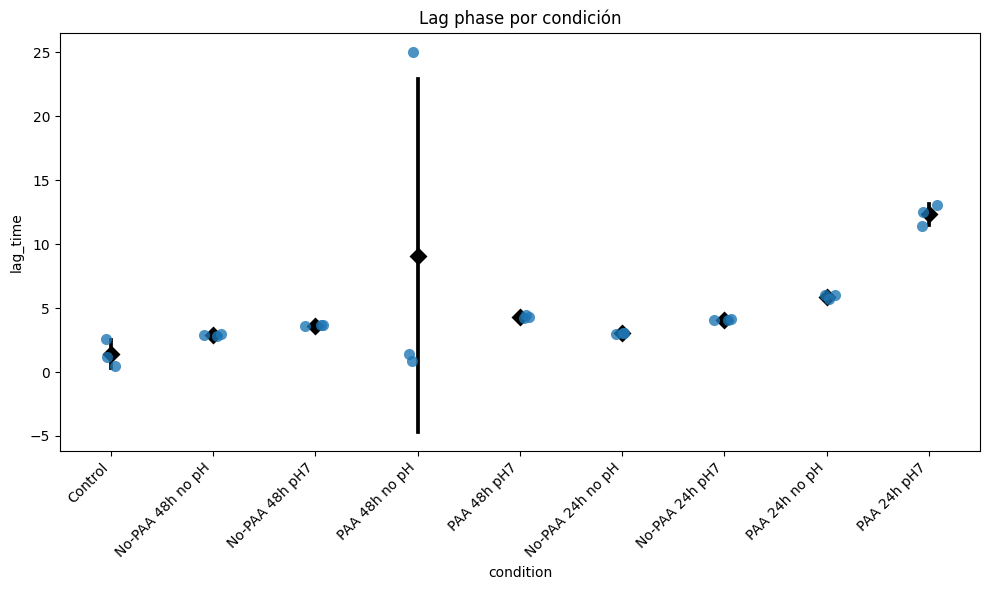

/tmp/ipython-input-3517288058.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x="condition", y=param, data=df,
/tmp/ipython-input-3517288058.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="condition", y=param, data=df,


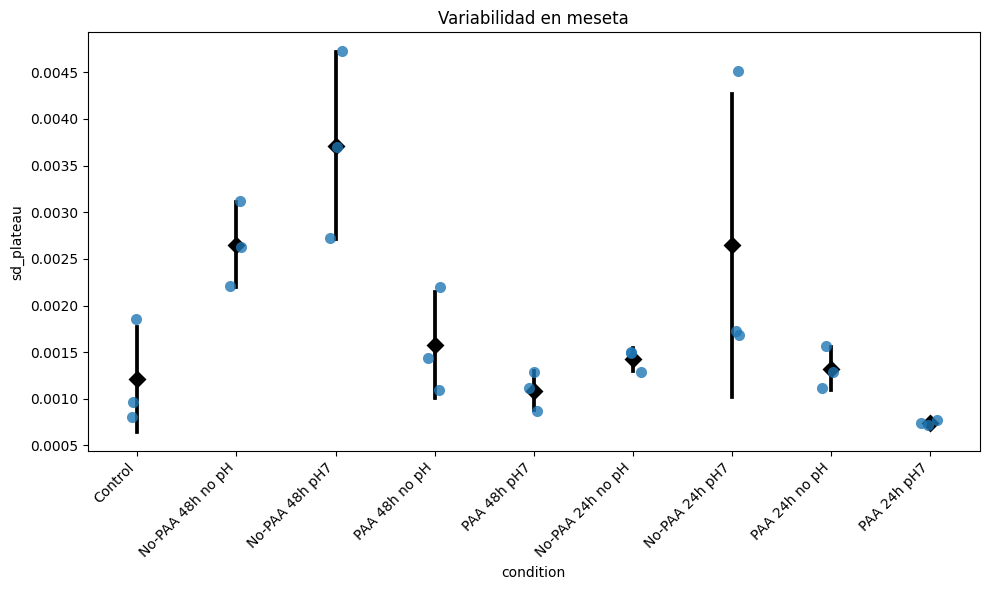

In [13]:
import seaborn as sns

# ==============================
# DOT PLOT para un parámetro
# ==============================

def dotplot_param(df, param, title=""):
    plt.figure(figsize=(10,6))
    sns.stripplot(x="condition", y=param, data=df,
                  jitter=True, size=8, alpha=0.8)
    sns.pointplot(x="condition", y=param, data=df,
                  estimator=np.mean, ci='sd',
                  join=False, markers='D', color='black')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Ejemplo 1: ∆OD
dotplot_param(summary_decM, "delta_OD", "ΔOD por condición")

# Ejemplo 2: slope máxima
dotplot_param(summary_decM, "slope_max", "Slope máxima por condición")

# Ejemplo 3: t50
dotplot_param(summary_decM, "t50", "Tiempo al 50% (t50)")

# Ejemplo 4: lag time
dotplot_param(summary_decM, "lag_time", "Lag phase por condición")

# Ejemplo 5: ruido meseta
dotplot_param(summary_decM, "sd_plateau", "Variabilidad en meseta")


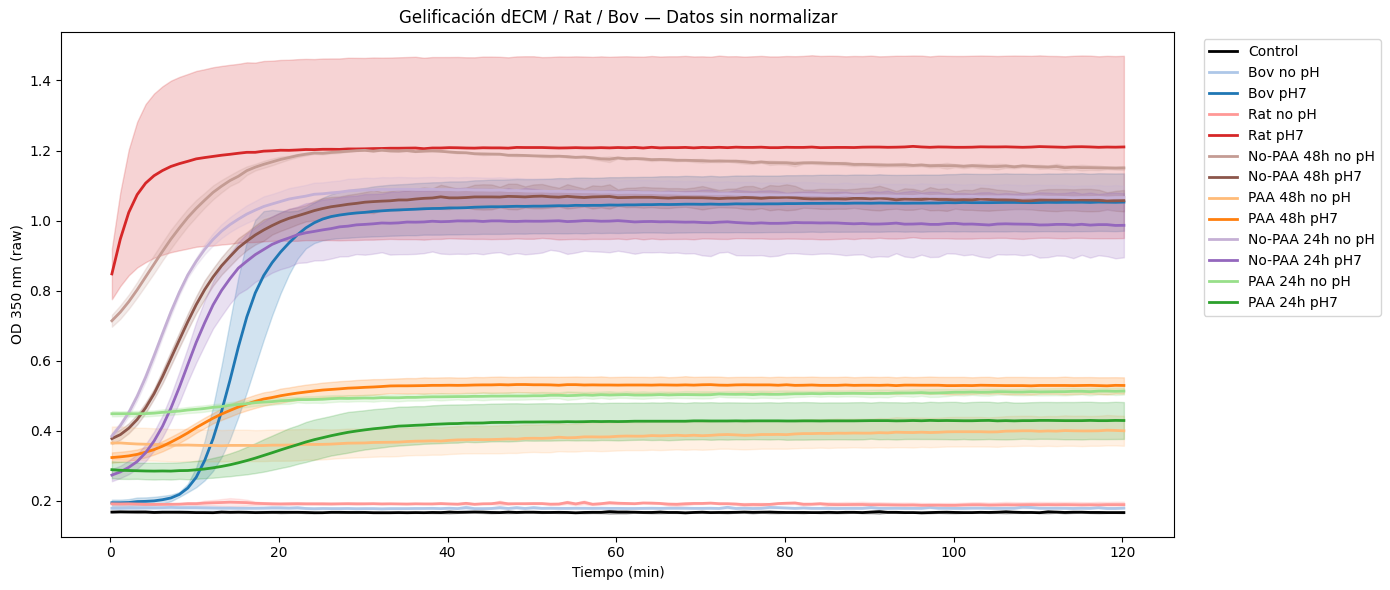

PCA 1 – Validación (incluye Bov/Rat/Control y dECM) – Varianza explicada: PC1=0.49, PC2=0.17


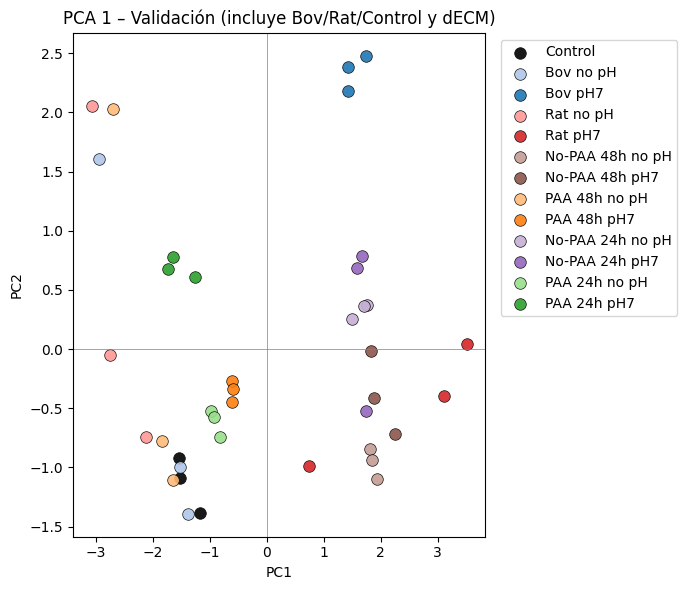

PCA 2 – dECM (PAA / No PAA, 24h / 48h, pH7 / no pH) – Varianza explicada: PC1=0.55, PC2=0.15


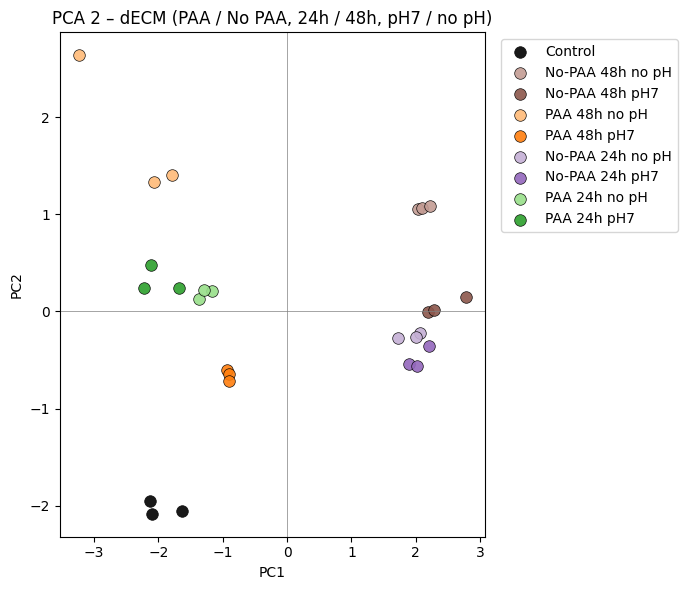

/tmp/ipython-input-2418455974.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'li

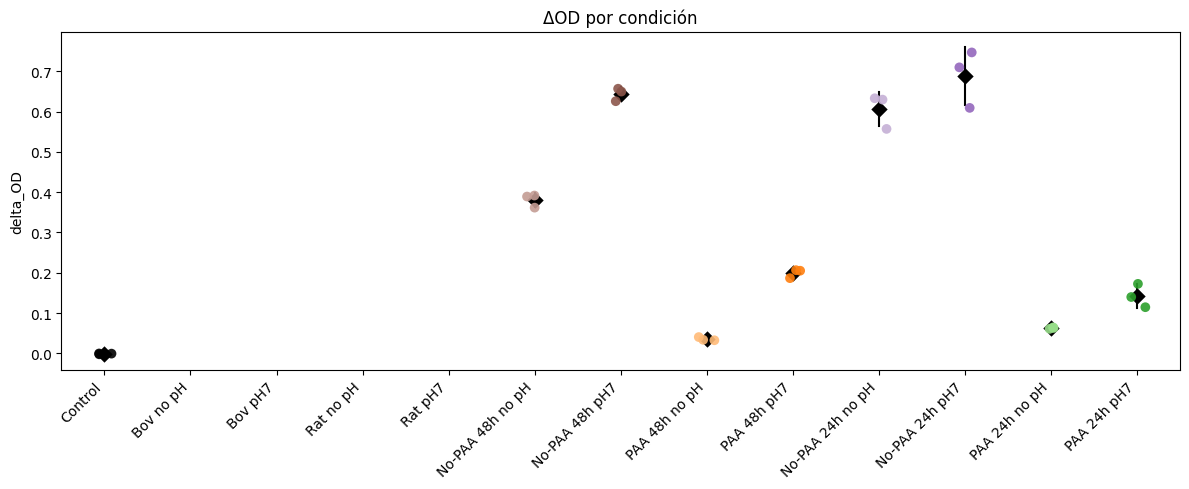

/tmp/ipython-input-2418455974.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'li

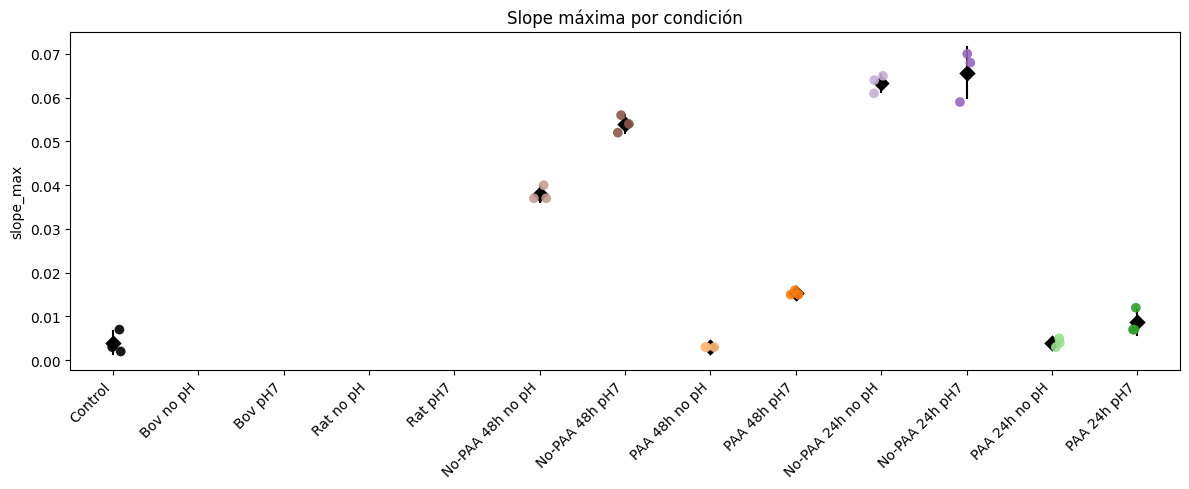

/tmp/ipython-input-2418455974.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'li

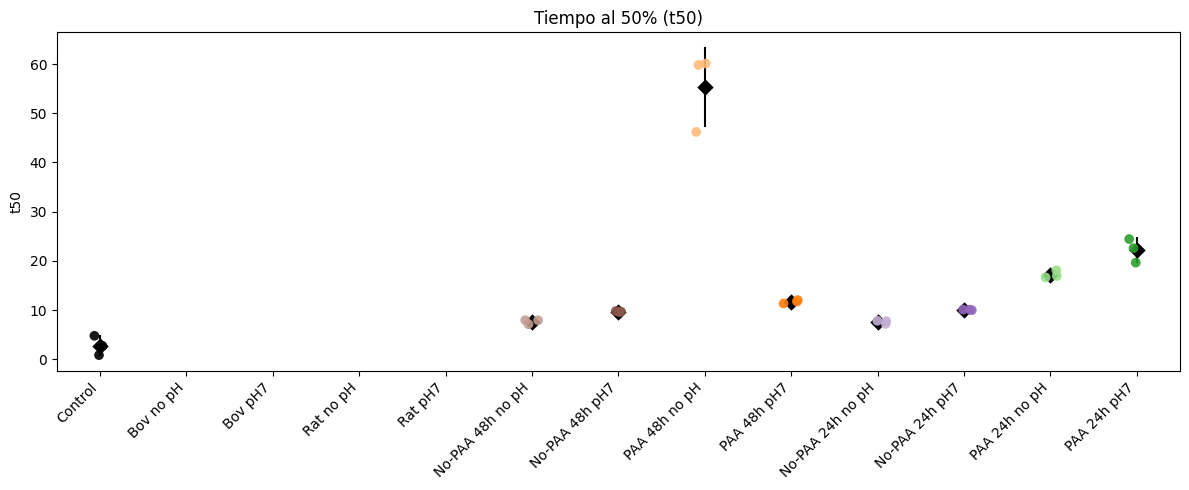

/tmp/ipython-input-2418455974.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'li

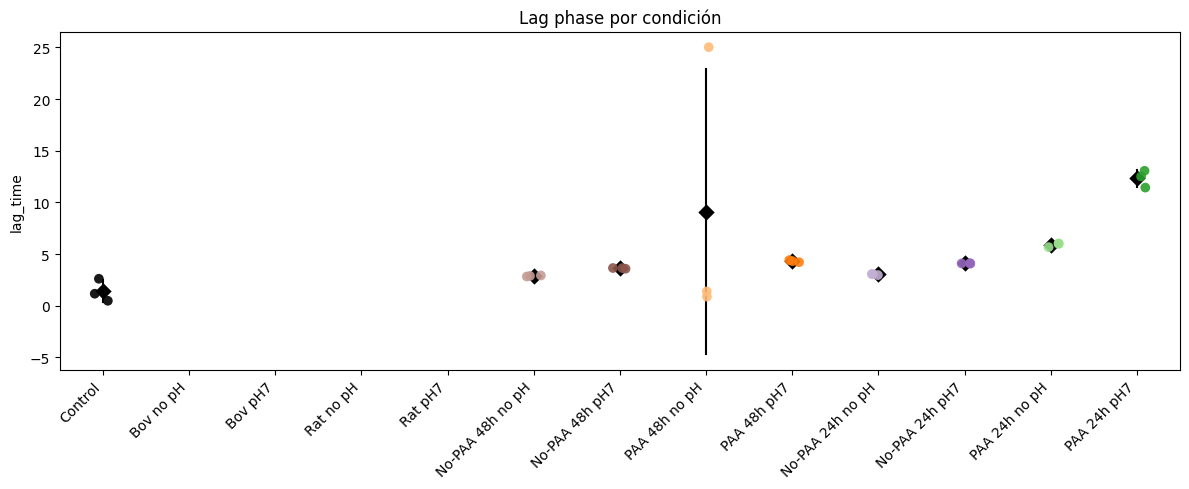

/tmp/ipython-input-2418455974.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipython-input-2418455974.py:155: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'li

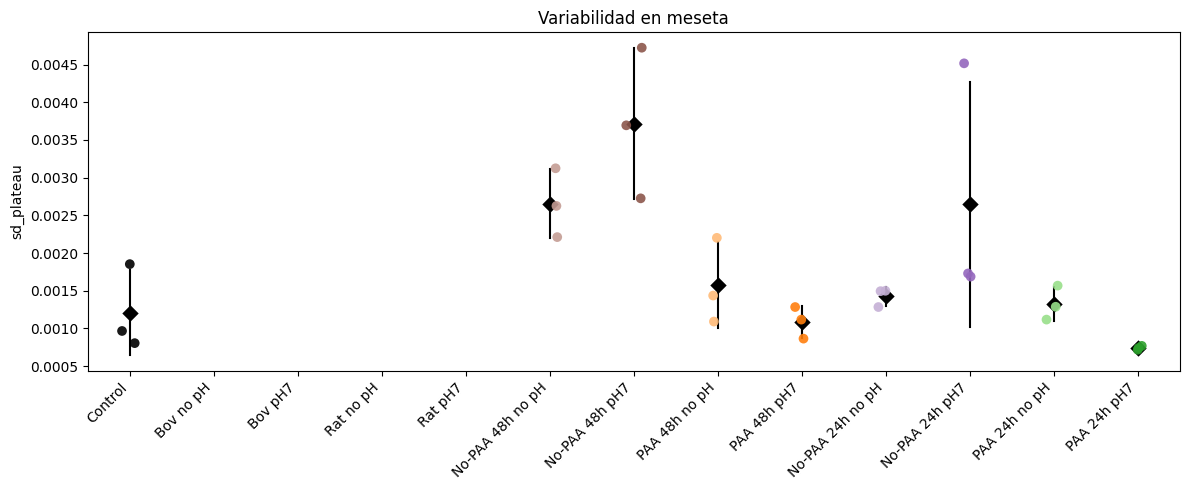

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================
# PALETA Y ORDEN DE CONDICIONES
# ==============================

color_map = {
    "Control": "#000000",

    "Bov pH7":   "#1f77b4",
    "Bov no pH": "#aec7e8",

    "Rat pH7":   "#d62728",
    "Rat no pH": "#ff9896",

    "PAA 24h pH7":   "#2ca02c",
    "PAA 24h no pH": "#98df8a",

    "PAA 48h pH7":   "#ff7f0e",
    "PAA 48h no pH": "#ffbb78",

    "No-PAA 24h pH7":   "#9467bd",
    "No-PAA 24h no pH": "#c5b0d5",

    "No-PAA 48h pH7":   "#8c564b",
    "No-PAA 48h no pH": "#c49c94",
}

condition_order = [
    "Control",
    "Bov no pH", "Bov pH7",
    "Rat no pH", "Rat pH7",
    "No-PAA 48h no pH", "No-PAA 48h pH7",
    "PAA 48h no pH", "PAA 48h pH7",
    "No-PAA 24h no pH", "No-PAA 24h pH7",
    "PAA 24h no pH", "PAA 24h pH7",
]

# ==============================
# 1) CURVAS DE GELIFICACIÓN
# ==============================

def plot_timecourses(long_df, title="Gelificación dECM / Rat / Bov — Datos sin normalizar"):
    plt.figure(figsize=(14, 6))
    ax = plt.gca()

    for cond in condition_order:
        sub = long_df[long_df["condition"] == cond]
        if sub.empty:
            continue

        stats = (
            sub.groupby("time_min")["OD"]
               .agg(["mean", "std"])
               .reset_index()
               .rename(columns={"mean": "OD_mean", "std": "OD_sd"})
        )

        color = color_map.get(cond, "#999999")

        ax.plot(
            stats["time_min"],
            stats["OD_mean"],
            label=cond,
            color=color,
            linewidth=2.0,
        )

        ax.fill_between(
            stats["time_min"],
            stats["OD_mean"] - stats["OD_sd"],
            stats["OD_mean"] + stats["OD_sd"],
            color=color,
            alpha=0.2,
        )

    ax.set_xlabel("Tiempo (min)")
    ax.set_ylabel("OD 350 nm (raw)")
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ==============================
# 2) PCA
# ==============================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ["baseline", "plateau", "delta_OD", "slope_max", "t50", "lag_time", "sd_plateau"]

def run_pca_plot(df_in, title="PCA"):
    X = df_in[features].values
    X_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X_scaled)

    df_plot = df_in.copy()
    df_plot["PC1"] = pcs[:, 0]
    df_plot["PC2"] = pcs[:, 1]

    print(f"{title} – Varianza explicada: PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f}")

    plt.figure(figsize=(7, 6))
    ax = plt.gca()

    for cond in condition_order:
        sub = df_plot[df_plot["condition"] == cond]
        if sub.empty:
            continue

        ax.scatter(
            sub["PC1"],
            sub["PC2"],
            label=cond,
            s=70,
            alpha=0.9,
            color=color_map.get(cond, "#999999"),
            edgecolor="k",
            linewidth=0.5,
        )

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.axvline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ==============================
# 3) DOT PLOTS
# ==============================

def dotplot_param(df, param, title=""):
    plt.figure(figsize=(12, 5))
    ax = plt.gca()

    sns.stripplot(
        x="condition",
        y=param,
        data=df,
        order=condition_order,
        palette=color_map,
        size=7,
        alpha=0.9,
        ax=ax,
    )

    sns.pointplot(
        x="condition",
        y=param,
        data=df,
        order=condition_order,
        join=False,
        estimator=np.mean,
        ci="sd",
        color="black",
        markers="D",
        scale=1.1,
        errwidth=1.5,
        ax=ax,
    )

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# ==============================
# 4) CREAR summary_decM (solo dECM) Y PINTAR TODO
# ==============================

summary_decM = summary_df[
    ~summary_df["condition"].isin(["Bov pH7", "Bov no pH", "Rat pH7", "Rat no pH"])
].reset_index(drop=True)

# --- Curvas ---
plot_timecourses(long_df)

# --- PCA 1: todo ---
run_pca_plot(summary_df, title="PCA 1 – Validación (incluye Bov/Rat/Control y dECM)")

# --- PCA 2: solo dECM ---
run_pca_plot(summary_decM, title="PCA 2 – dECM (PAA / No PAA, 24h / 48h, pH7 / no pH)")

# --- Dot plots ---
dotplot_param(summary_decM, "delta_OD",  "ΔOD por condición")
dotplot_param(summary_decM, "slope_max", "Slope máxima por condición")
dotplot_param(summary_decM, "t50",       "Tiempo al 50% (t50)")
dotplot_param(summary_decM, "lag_time",  "Lag phase por condición")
dotplot_param(summary_decM, "sd_plateau","Variabilidad en meseta")
